# LSTM Travel Time + Speed Prediction - N101.3

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N101.3')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6396,42,44,2021042800
6410,42,44,2021042800
6424,42,44,2021042800
6438,42,44,2021042800
6452,42,44,2021042800
...,...,...,...
294407,42,44,2021051509
294421,42,44,2021051509
294435,42,44,2021051509
294449,42,44,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,42.0,44.0
2021042801,42.0,44.0
2021042802,42.0,44.0
2021042803,42.0,44.0
2021042804,42.0,44.0
...,...,...
2021051505,42.0,44.0
2021051506,42.0,44.0
2021051507,42.0,44.0


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed



,currentSpeed
timeStamp,
2021042800,1.0
2021042801,1.0
2021042802,1.0
2021042803,1.0
2021042804,1.0
...,...
2021051505,1.0
2021051506,1.0
2021051507,1.0


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 12s 1s/step - loss: 0.6989 - mae: 0.6445 - rmse: 0.6219 - val_loss: 0.0233 - val_mae: 0.0233 - val_rmse: 0.0233
Epoch 2/300
3/3 [==============================] - 0s 102ms/step - loss: 0.4750 - mae: 0.2787 - rmse: 0.4290 - val_loss: 4.6213e-04 - val_mae: 4.6186e-04 - val_rmse: 4.6213e-04
Epoch 3/300
3/3 [==============================] - 0s 98ms/step - loss: 0.4950 - mae: 0.2437 - rmse: 0.4413 - val_loss: 9.0724e-04 - val_mae: 9.0655e-04 - val_rmse: 9.0724e-04
Epoch 4/300
3/3 [==============================] - 0s 121ms/step - loss: 0.4942 - mae: 0.2422 - rmse: 0.4404 - val_loss: 0.0034 - val_mae: 0.0034 - val_rmse: 0.0034
Epoch 5/300
3/3 [==============================] - 0s 122ms/step - loss: 0.4909 - mae: 0.2382 - rmse: 0.4352 - val_loss: 0.0677 - val_mae: 0.0676 - val_rmse: 0.0677
Epoch 6/300
3/3 [==============================] - 0s 109ms/step - loss: 0.4656 - mae: 0.3253 - rmse: 0.4138 - val_loss: 0.0475 - val_mae: 0.0474 - val_rm

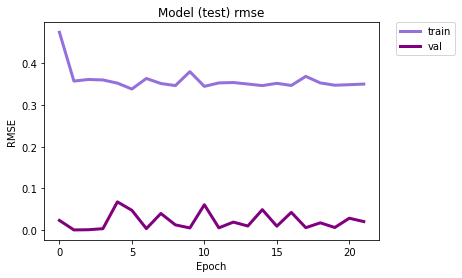

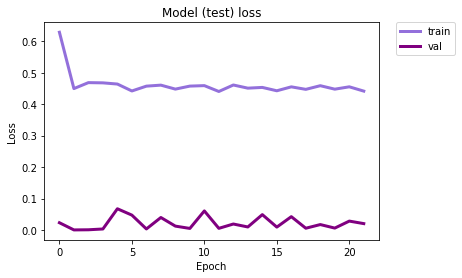

Epoch 1/300
5/5 [==============================] - 1s 120ms/step - loss: 0.3743 - mae: 0.1899 - rmse: 0.3568 - val_loss: 0.1157 - val_mae: 0.0742 - val_rmse: 0.1157
Epoch 2/300
5/5 [==============================] - 1s 101ms/step - loss: 0.3745 - mae: 0.1896 - rmse: 0.3569 - val_loss: 0.1156 - val_mae: 0.0741 - val_rmse: 0.1156
Epoch 3/300
5/5 [==============================] - 1s 109ms/step - loss: 0.3746 - mae: 0.1890 - rmse: 0.3570 - val_loss: 0.1155 - val_mae: 0.0739 - val_rmse: 0.1155
Epoch 4/300
5/5 [==============================] - 0s 93ms/step - loss: 0.3744 - mae: 0.1893 - rmse: 0.3567 - val_loss: 0.1152 - val_mae: 0.0736 - val_rmse: 0.1152
Epoch 5/300
5/5 [==============================] - 1s 100ms/step - loss: 0.3743 - mae: 0.1886 - rmse: 0.3565 - val_loss: 0.1149 - val_mae: 0.0729 - val_rmse: 0.1149
Epoch 6/300
5/5 [==============================] - 0s 98ms/step - loss: 0.3735 - mae: 0.1876 - rmse: 0.3559 - val_loss: 0.1137 - val_mae: 0.0711 - val_rmse: 0.1137
Epoch 7/300


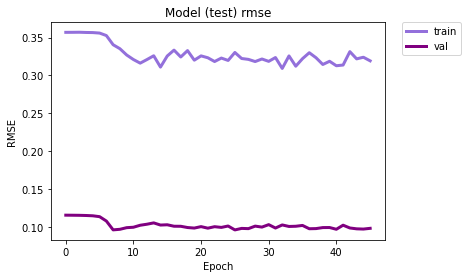

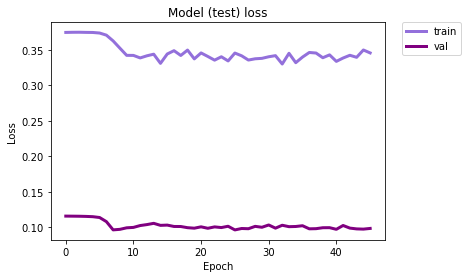

Epoch 1/300
7/7 [==============================] - 0s 72ms/step - loss: 0.2819 - mae: 0.1752 - rmse: 0.2716 - val_loss: 0.1617 - val_mae: 0.0973 - val_rmse: 0.1224
Epoch 2/300
7/7 [==============================] - 0s 68ms/step - loss: 0.2815 - mae: 0.1791 - rmse: 0.2716 - val_loss: 0.1618 - val_mae: 0.0966 - val_rmse: 0.1216
Epoch 3/300
7/7 [==============================] - 0s 69ms/step - loss: 0.2687 - mae: 0.1716 - rmse: 0.2559 - val_loss: 0.1617 - val_mae: 0.1013 - val_rmse: 0.1266
Epoch 4/300
7/7 [==============================] - 0s 71ms/step - loss: 0.2727 - mae: 0.1744 - rmse: 0.2625 - val_loss: 0.1616 - val_mae: 0.0995 - val_rmse: 0.1248
Epoch 5/300
7/7 [==============================] - 0s 72ms/step - loss: 0.2779 - mae: 0.1761 - rmse: 0.2687 - val_loss: 0.1617 - val_mae: 0.0961 - val_rmse: 0.1209
Epoch 6/300
7/7 [==============================] - 0s 52ms/step - loss: 0.2817 - mae: 0.1778 - rmse: 0.2699 - val_loss: 0.1615 - val_mae: 0.0977 - val_rmse: 0.1227
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 53ms/step - loss: 0.2745 - mae: 0.1734 - rmse: 0.2640 - val_loss: 0.1587 - val_mae: 0.0989 - val_rmse: 0.1204
Epoch 52/300
7/7 [==============================] - 0s 55ms/step - loss: 0.2694 - mae: 0.1705 - rmse: 0.2574 - val_loss: 0.1586 - val_mae: 0.0983 - val_rmse: 0.1197
Epoch 53/300
7/7 [==============================] - 0s 60ms/step - loss: 0.2664 - mae: 0.1695 - rmse: 0.2550 - val_loss: 0.1587 - val_mae: 0.1018 - val_rmse: 0.1229
Epoch 54/300
7/7 [==============================] - 0s 51ms/step - loss: 0.2669 - mae: 0.1721 - rmse: 0.2565 - val_loss: 0.1585 - val_mae: 0.1007 - val_rmse: 0.1217
Epoch 55/300
7/7 [==============================] - 0s 52ms/step - loss: 0.2719 - mae: 0.1709 - rmse: 0.2603 - val_loss: 0.1585 - val_mae: 0.1015 - val_rmse: 0.1223
Epoch 56/300
7/7 [==============================] - 0s 57ms/step - loss: 0.2719 - mae: 0.1734 - rmse: 0.2596 - val_loss: 0.1583 - val_mae: 0.0995 - val_rmse: 0.1204
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2645 - mae: 0.1608 - rmse: 0.2547 - val_loss: 0.1537 - val_mae: 0.0900 - val_rmse: 0.1057
Epoch 102/300
7/7 [==============================] - 0s 50ms/step - loss: 0.2546 - mae: 0.1590 - rmse: 0.2446 - val_loss: 0.1533 - val_mae: 0.0951 - val_rmse: 0.1094
Epoch 103/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2560 - mae: 0.1536 - rmse: 0.2464 - val_loss: 0.1535 - val_mae: 0.0978 - val_rmse: 0.1116
Epoch 104/300
7/7 [==============================] - 0s 47ms/step - loss: 0.2596 - mae: 0.1574 - rmse: 0.2483 - val_loss: 0.1532 - val_mae: 0.0963 - val_rmse: 0.1102
Epoch 105/300
7/7 [==============================] - 0s 49ms/step - loss: 0.2613 - mae: 0.1577 - rmse: 0.2523 - val_loss: 0.1530 - val_mae: 0.0914 - val_rmse: 0.1061
Epoch 106/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2583 - mae: 0.1551 - rmse: 0.2487 - val_loss: 0.1527 - val_mae: 0.0936 - val_rmse: 0.1075
Epoc

7/7 [==============================] - 0s 67ms/step - loss: 0.2502 - mae: 0.1522 - rmse: 0.2418 - val_loss: 0.1509 - val_mae: 0.0884 - val_rmse: 0.1016
Epoch 151/300
7/7 [==============================] - 1s 98ms/step - loss: 0.2593 - mae: 0.1533 - rmse: 0.2525 - val_loss: 0.1518 - val_mae: 0.0849 - val_rmse: 0.0994
Epoch 152/300
7/7 [==============================] - 1s 79ms/step - loss: 0.2586 - mae: 0.1498 - rmse: 0.2496 - val_loss: 0.1516 - val_mae: 0.0855 - val_rmse: 0.0998
Epoch 153/300
7/7 [==============================] - 0s 53ms/step - loss: 0.2569 - mae: 0.1512 - rmse: 0.2482 - val_loss: 0.1510 - val_mae: 0.0872 - val_rmse: 0.1007
Epoch 154/300
7/7 [==============================] - 0s 76ms/step - loss: 0.2544 - mae: 0.1477 - rmse: 0.2429 - val_loss: 0.1506 - val_mae: 0.0895 - val_rmse: 0.1022
Epoch 155/300
7/7 [==============================] - 0s 72ms/step - loss: 0.2539 - mae: 0.1505 - rmse: 0.2456 - val_loss: 0.1513 - val_mae: 0.0857 - val_rmse: 0.0998
Epoch 156/300
7/7 

7/7 [==============================] - 0s 49ms/step - loss: 0.2490 - mae: 0.1462 - rmse: 0.2409 - val_loss: 0.1500 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 200/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2521 - mae: 0.1519 - rmse: 0.2428 - val_loss: 0.1500 - val_mae: 0.0886 - val_rmse: 0.1016
Epoch 201/300
7/7 [==============================] - 0s 47ms/step - loss: 0.2563 - mae: 0.1519 - rmse: 0.2481 - val_loss: 0.1504 - val_mae: 0.0866 - val_rmse: 0.1003
Epoch 202/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2463 - mae: 0.1450 - rmse: 0.2356 - val_loss: 0.1499 - val_mae: 0.0880 - val_rmse: 0.1011
Epoch 203/300
7/7 [==============================] - 0s 50ms/step - loss: 0.2467 - mae: 0.1452 - rmse: 0.2385 - val_loss: 0.1502 - val_mae: 0.0865 - val_rmse: 0.1001
Epoch 204/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2579 - mae: 0.1535 - rmse: 0.2488 - val_loss: 0.1509 - val_mae: 0.0845 - val_rmse: 0.0990
Epoch 205/300
7/7 

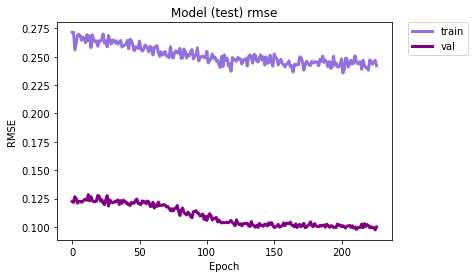

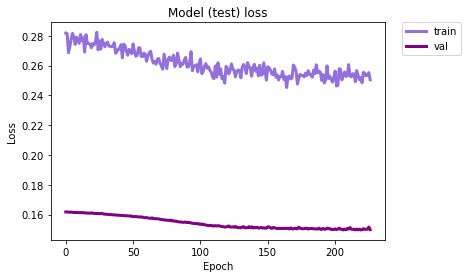

Epoch 1/300
9/9 [==============================] - 0s 50ms/step - loss: 0.2211 - mae: 0.1335 - rmse: 0.2091 - val_loss: 0.0637 - val_mae: 0.0557 - val_rmse: 0.0713
Epoch 2/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2226 - mae: 0.1305 - rmse: 0.2104 - val_loss: 0.0632 - val_mae: 0.0551 - val_rmse: 0.0709
Epoch 3/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2296 - mae: 0.1313 - rmse: 0.2175 - val_loss: 0.0593 - val_mae: 0.0505 - val_rmse: 0.0686
Epoch 4/300
9/9 [==============================] - 0s 45ms/step - loss: 0.2264 - mae: 0.1315 - rmse: 0.2143 - val_loss: 0.0580 - val_mae: 0.0490 - val_rmse: 0.0678
Epoch 5/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2238 - mae: 0.1297 - rmse: 0.2114 - val_loss: 0.0639 - val_mae: 0.0559 - val_rmse: 0.0714
Epoch 6/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2219 - mae: 0.1295 - rmse: 0.2083 - val_loss: 0.0626 - val_mae: 0.0542 - val_rmse: 0.0706
Epoch 7/300
9/9 

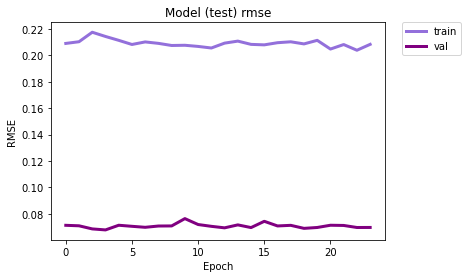

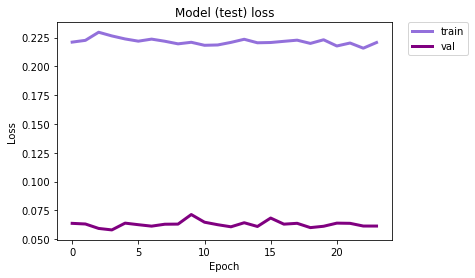

Epoch 1/300
11/11 [==============================] - 1s 58ms/step - loss: 0.1935 - mae: 0.1141 - rmse: 0.1887 - val_loss: 0.1359 - val_mae: 0.0881 - val_rmse: 0.1313
Epoch 2/300
11/11 [==============================] - 1s 50ms/step - loss: 0.1993 - mae: 0.1182 - rmse: 0.1939 - val_loss: 0.1355 - val_mae: 0.0881 - val_rmse: 0.1309
Epoch 3/300
11/11 [==============================] - 1s 61ms/step - loss: 0.1955 - mae: 0.1176 - rmse: 0.1897 - val_loss: 0.1325 - val_mae: 0.0875 - val_rmse: 0.1280
Epoch 4/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1932 - mae: 0.1144 - rmse: 0.1872 - val_loss: 0.1324 - val_mae: 0.0871 - val_rmse: 0.1279
Epoch 5/300
11/11 [==============================] - 0s 46ms/step - loss: 0.1926 - mae: 0.1119 - rmse: 0.1868 - val_loss: 0.1335 - val_mae: 0.0872 - val_rmse: 0.1289
Epoch 6/300
11/11 [==============================] - 1s 47ms/step - loss: 0.1944 - mae: 0.1150 - rmse: 0.1891 - val_loss: 0.1337 - val_mae: 0.0873 - val_rmse: 0.1291
Epoc

11/11 [==============================] - 1s 58ms/step - loss: 0.1933 - mae: 0.1128 - rmse: 0.1872 - val_loss: 0.1336 - val_mae: 0.0861 - val_rmse: 0.1289
Epoch 51/300
11/11 [==============================] - 1s 56ms/step - loss: 0.1938 - mae: 0.1143 - rmse: 0.1891 - val_loss: 0.1350 - val_mae: 0.0865 - val_rmse: 0.1303
Epoch 52/300
11/11 [==============================] - 1s 49ms/step - loss: 0.1972 - mae: 0.1172 - rmse: 0.1916 - val_loss: 0.1343 - val_mae: 0.0862 - val_rmse: 0.1297
Epoch 53/300
11/11 [==============================] - 1s 67ms/step - loss: 0.1915 - mae: 0.1080 - rmse: 0.1864 - val_loss: 0.1347 - val_mae: 0.0863 - val_rmse: 0.1300
Epoch 54/300
11/11 [==============================] - 1s 64ms/step - loss: 0.1873 - mae: 0.1096 - rmse: 0.1819 - val_loss: 0.1332 - val_mae: 0.0859 - val_rmse: 0.1285
Epoch 55/300
11/11 [==============================] - 1s 115ms/step - loss: 0.1921 - mae: 0.1127 - rmse: 0.1865 - val_loss: 0.1334 - val_mae: 0.0861 - val_rmse: 0.1288
Epoch 56/3

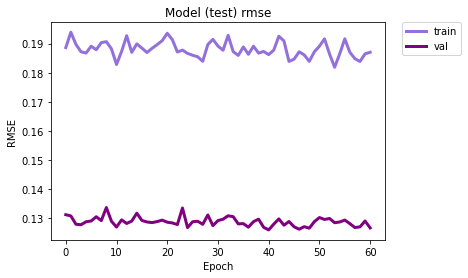

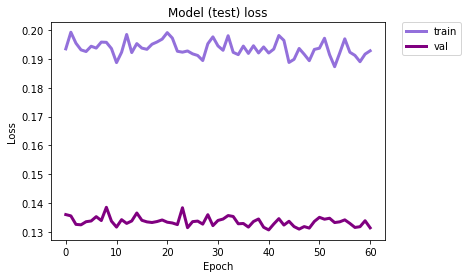

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.95062417
Transformed yhat 16.20204
yhat -0.9431164
Transformed yhat 16.301332
yhat -0.9361952
Transformed yhat 16.39287
yhat -0.92847973
Transformed yhat 16.494911
yhat -0.92280704
Transformed yhat 16.569935
yhat -0.9166266
Transformed yhat 16.651674
yhat -0.91495633
Transformed yhat 16.673763
yhat -0.92336345
Transformed yhat 16.562574
yhat -0.9342147
Transformed yhat 16.419062
yhat -0.9420717
Transformed yhat 16.31515
yhat -0.9447266
Transformed yhat 16.280037
yhat -0.9473789
Transformed yhat 16.244959
Real data: [16.21849852 17.18830813 16.59878481 17.19735783 16.16957047 17.29879403
 20.74613306 21.14949112 19.08407112 15.54901961 15.54901961 15.54901961
 15.54901961 15.54901961 15.92135012 15.54901961 15.54901961 15.54901961
 15.54901961 15.54901961 15.54901961 15.54901961 15.54901961 15.54901961]
Forecasting values: [16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.7, 16.6, 16.4, 16.3, 16.3, 16.2]


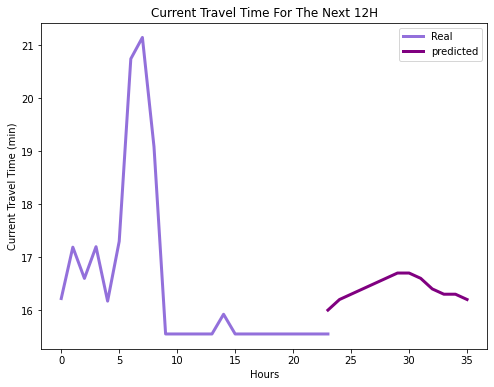

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.3',forecasts[i],hour[i]
        writer.writerow(d)
        

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 6s 517ms/step - loss: 0.6480 - mae: 0.5585 - rmse: 0.5843 - val_loss: 0.2921 - val_mae: 0.2916 - val_rmse: 0.2921
Epoch 2/300
3/3 [==============================] - 0s 62ms/step - loss: 0.5447 - mae: 0.4718 - rmse: 0.4949 - val_loss: 0.1287 - val_mae: 0.1283 - val_rmse: 0.1287
Epoch 3/300
3/3 [==============================] - 0s 60ms/step - loss: 0.5655 - mae: 0.4484 - rmse: 0.5267 - val_loss: 0.0078 - val_mae: 0.0078 - val_rmse: 0.0078
Epoch 4/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6257 - mae: 0.3715 - rmse: 0.5695 - val_loss: 0.0613 - val_mae: 0.0610 - val_rmse: 0.0613
Epoch 5/300
3/3 [==============================] - 0s 59ms/step - loss: 0.5574 - mae: 0.3914 - rmse: 0.5172 - val_loss: 0.0144 - val_mae: 0.0143 - val_rmse: 0.0144
Epoch 6/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6058 - mae: 0.3677 - rmse: 0.5515 - val_loss: 0.1095 - val_mae: 0.1092 - val_rmse: 0.1095
Epoch 7/300
3/3

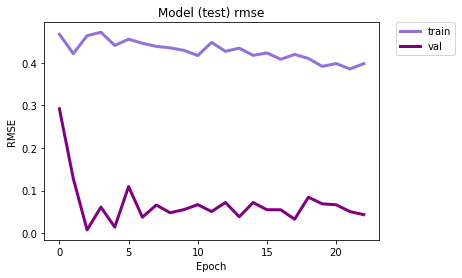

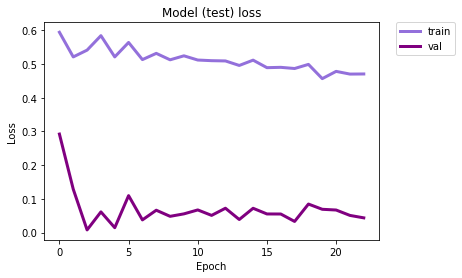

Epoch 1/300
5/5 [==============================] - 0s 62ms/step - loss: 0.5429 - mae: 0.3232 - rmse: 0.5376 - val_loss: 0.2594 - val_mae: 0.1719 - val_rmse: 0.2594
Epoch 2/300
5/5 [==============================] - 0s 48ms/step - loss: 0.5275 - mae: 0.3148 - rmse: 0.5200 - val_loss: 0.2469 - val_mae: 0.1552 - val_rmse: 0.2469
Epoch 3/300
5/5 [==============================] - 0s 48ms/step - loss: 0.5042 - mae: 0.3083 - rmse: 0.4954 - val_loss: 0.2278 - val_mae: 0.1490 - val_rmse: 0.2278
Epoch 4/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4789 - mae: 0.3165 - rmse: 0.4749 - val_loss: 0.2134 - val_mae: 0.1531 - val_rmse: 0.2134
Epoch 5/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4806 - mae: 0.3346 - rmse: 0.4735 - val_loss: 0.2066 - val_mae: 0.1607 - val_rmse: 0.2066
Epoch 6/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4695 - mae: 0.3413 - rmse: 0.4632 - val_loss: 0.2056 - val_mae: 0.1675 - val_rmse: 0.2056
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 0s 53ms/step - loss: 0.4186 - mae: 0.3026 - rmse: 0.4040 - val_loss: 0.1930 - val_mae: 0.1430 - val_rmse: 0.1930
Epoch 52/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4185 - mae: 0.3011 - rmse: 0.3995 - val_loss: 0.1938 - val_mae: 0.1432 - val_rmse: 0.1938
Epoch 53/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4154 - mae: 0.2931 - rmse: 0.4053 - val_loss: 0.1936 - val_mae: 0.1417 - val_rmse: 0.1936
Epoch 54/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4116 - mae: 0.2952 - rmse: 0.3977 - val_loss: 0.1949 - val_mae: 0.1434 - val_rmse: 0.1949
Epoch 55/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4077 - mae: 0.2855 - rmse: 0.3955 - val_loss: 0.1958 - val_mae: 0.1442 - val_rmse: 0.1958
Epoch 56/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4061 - mae: 0.2807 - rmse: 0.3973 - val_loss: 0.1958 - val_mae: 0.1426 - val_rmse: 0.1958
Epoch 57/3

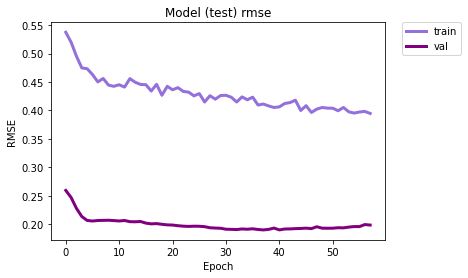

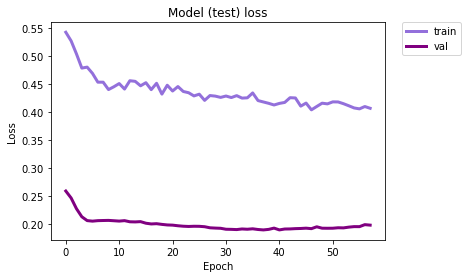

Epoch 1/300
7/7 [==============================] - 0s 53ms/step - loss: 0.3630 - mae: 0.2706 - rmse: 0.3580 - val_loss: 0.2824 - val_mae: 0.2079 - val_rmse: 0.2257
Epoch 2/300
7/7 [==============================] - 0s 46ms/step - loss: 0.3737 - mae: 0.2770 - rmse: 0.3686 - val_loss: 0.2805 - val_mae: 0.2006 - val_rmse: 0.2180
Epoch 3/300
7/7 [==============================] - 0s 48ms/step - loss: 0.3647 - mae: 0.2649 - rmse: 0.3574 - val_loss: 0.2808 - val_mae: 0.2044 - val_rmse: 0.2210
Epoch 4/300
7/7 [==============================] - 0s 50ms/step - loss: 0.3642 - mae: 0.2673 - rmse: 0.3593 - val_loss: 0.2796 - val_mae: 0.2006 - val_rmse: 0.2167
Epoch 5/300
7/7 [==============================] - 0s 50ms/step - loss: 0.3619 - mae: 0.2639 - rmse: 0.3579 - val_loss: 0.2786 - val_mae: 0.1965 - val_rmse: 0.2124
Epoch 6/300
7/7 [==============================] - 0s 46ms/step - loss: 0.3676 - mae: 0.2641 - rmse: 0.3622 - val_loss: 0.2779 - val_mae: 0.1932 - val_rmse: 0.2089
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 65ms/step - loss: 0.3514 - mae: 0.2419 - rmse: 0.3472 - val_loss: 0.2669 - val_mae: 0.1755 - val_rmse: 0.1826
Epoch 52/300
7/7 [==============================] - 0s 47ms/step - loss: 0.3419 - mae: 0.2388 - rmse: 0.3367 - val_loss: 0.2669 - val_mae: 0.1733 - val_rmse: 0.1810
Epoch 53/300
7/7 [==============================] - 0s 49ms/step - loss: 0.3533 - mae: 0.2448 - rmse: 0.3473 - val_loss: 0.2670 - val_mae: 0.1740 - val_rmse: 0.1816
Epoch 54/300
7/7 [==============================] - 0s 47ms/step - loss: 0.3455 - mae: 0.2427 - rmse: 0.3390 - val_loss: 0.2664 - val_mae: 0.1747 - val_rmse: 0.1818
Epoch 55/300
7/7 [==============================] - 0s 61ms/step - loss: 0.3509 - mae: 0.2424 - rmse: 0.3448 - val_loss: 0.2669 - val_mae: 0.1708 - val_rmse: 0.1794
Epoch 56/300
7/7 [==============================] - 0s 46ms/step - loss: 0.3440 - mae: 0.2347 - rmse: 0.3401 - val_loss: 0.2665 - val_mae: 0.1742 - val_rmse: 0.1818
Epoch 57/3

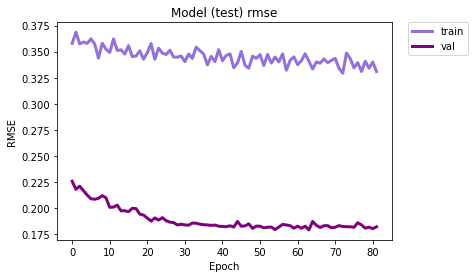

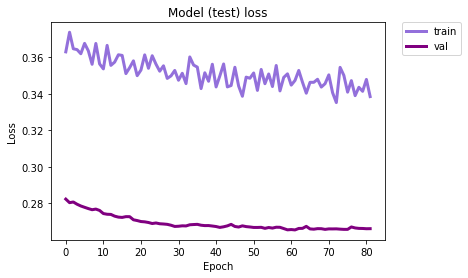

Epoch 1/300
9/9 [==============================] - 1s 94ms/step - loss: 0.3253 - mae: 0.2235 - rmse: 0.3101 - val_loss: 0.1432 - val_mae: 0.1310 - val_rmse: 0.1521
Epoch 2/300
9/9 [==============================] - 1s 100ms/step - loss: 0.3160 - mae: 0.2165 - rmse: 0.3011 - val_loss: 0.1397 - val_mae: 0.1271 - val_rmse: 0.1498
Epoch 3/300
9/9 [==============================] - 1s 63ms/step - loss: 0.3271 - mae: 0.2227 - rmse: 0.3103 - val_loss: 0.1522 - val_mae: 0.1408 - val_rmse: 0.1581
Epoch 4/300
9/9 [==============================] - 0s 52ms/step - loss: 0.3246 - mae: 0.2191 - rmse: 0.3092 - val_loss: 0.1385 - val_mae: 0.1258 - val_rmse: 0.1491
Epoch 5/300
9/9 [==============================] - 1s 86ms/step - loss: 0.3183 - mae: 0.2156 - rmse: 0.3019 - val_loss: 0.1460 - val_mae: 0.1340 - val_rmse: 0.1538
Epoch 6/300
9/9 [==============================] - 1s 72ms/step - loss: 0.3245 - mae: 0.2186 - rmse: 0.3074 - val_loss: 0.1419 - val_mae: 0.1293 - val_rmse: 0.1510
Epoch 7/300
9/9

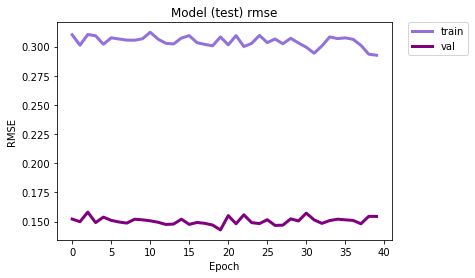

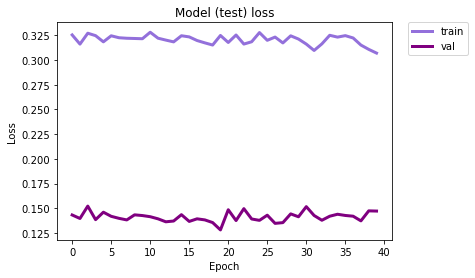

Epoch 1/300
11/11 [==============================] - 1s 61ms/step - loss: 0.2901 - mae: 0.2005 - rmse: 0.2852 - val_loss: 0.2720 - val_mae: 0.1757 - val_rmse: 0.2645
Epoch 2/300
11/11 [==============================] - 1s 47ms/step - loss: 0.3000 - mae: 0.2036 - rmse: 0.2971 - val_loss: 0.2792 - val_mae: 0.1811 - val_rmse: 0.2715
Epoch 3/300
11/11 [==============================] - 1s 60ms/step - loss: 0.2906 - mae: 0.1996 - rmse: 0.2886 - val_loss: 0.2781 - val_mae: 0.1803 - val_rmse: 0.2705
Epoch 4/300
11/11 [==============================] - 1s 65ms/step - loss: 0.2914 - mae: 0.2018 - rmse: 0.2871 - val_loss: 0.2735 - val_mae: 0.1769 - val_rmse: 0.2659
Epoch 5/300
11/11 [==============================] - 1s 60ms/step - loss: 0.2867 - mae: 0.1943 - rmse: 0.2838 - val_loss: 0.2748 - val_mae: 0.1778 - val_rmse: 0.2672
Epoch 6/300
11/11 [==============================] - 1s 72ms/step - loss: 0.2912 - mae: 0.2001 - rmse: 0.2866 - val_loss: 0.2813 - val_mae: 0.1823 - val_rmse: 0.2736
Epoc

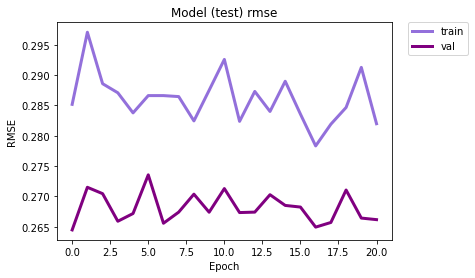

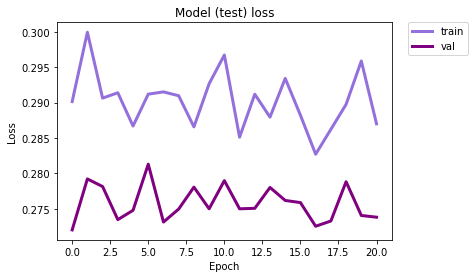

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.87047416
Transformed yhat 40.286957
yhat 0.847065
Transformed yhat 39.97736
yhat 0.8245739
Transformed yhat 39.679905
yhat 0.800494
Transformed yhat 39.361435
yhat 0.7830367
Transformed yhat 39.130554
yhat 0.7658431
Transformed yhat 38.90316
yhat 0.761451
Transformed yhat 38.845074
yhat 0.78719157
Transformed yhat 39.185505
yhat 0.8194696
Transformed yhat 39.612396
yhat 0.84269965
Transformed yhat 39.91963
yhat 0.85570925
Transformed yhat 40.091682
yhat 0.86845493
Transformed yhat 40.26025
Real data: [40.05769231 37.64705882 38.94117647 37.73076923 40.17647059 38.09615385
 29.80392157 29.68627451 35.61538462 42.         42.         42.
 42.         42.         40.94117647 42.         42.         42.
 42.         42.         42.         42.         42.         42.        ]
Forecasting values: [40.3, 40.0, 39.7, 39.4, 39.1, 38.9, 38.8, 39.2, 39.6, 39.9, 40.1, 40.3]


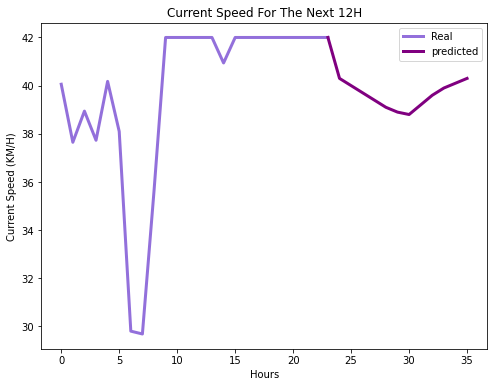

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.3',forecastSpeed[i],hour[i]
        writer.writerow(d)
